# Step 5: Modeling Real Data from FITS Files

In [2]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import corner
import astropy as ap
from astropy.io import fits
import astropy.io.fits as pyfits
from astropy.visualization import astropy_mpl_style
import pandas as pd
import math
import statistics
import scipy.ndimage as ndimage
import lenstronomy.Util.kernel_util as kernel_util
import lenstronomy.Plots.plot_util as plot_util
from lenstronomy.Util import util
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Plots import chain_plot
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Util import mask_util
from lenstronomy.ImSim.image_linear_solve import ImageLinearFit
from memory_profiler import memory_usage
from lenstronomy.Plots.lens_plot import lens_model_plot
from lenstronomy.LensModel.lens_model import LensModel
plt.style.use(astropy_mpl_style)
%matplotlib inline


In [3]:
# general functions
def get_data(filename):
    """
    Input: filename
    Output: data table and image array
    """
    hdu_list = fits.open(filename)  # open
    data = pd.DataFrame(hdu_list[2].data)  # get dataframe data
    image = hdu_list['IMAGE'].data  # get image data
    hdu_list.close()  # close
    return data, image


def plot_image(image_array):
    """
    Input: image array
    Output: plot of image with no grid
    """
    fig, ax = plt.subplots()
    ax.imshow(image_array, origin='lower')
    ax.set_xticks([])
    ax.set_xticks([])
    ax.grid(False)
    plt.show()
    plt.close()


def plot_all(coadd_id, image):
    """
    Input: coadd_id and image array (num_images, num_bands=3, numpix, numpix)
    Output: RGB image, and G, R, I plots for single image (indexed by coadd_id)
    """
    fig, ax = plt.subplots(1, 4, figsize=(16, 4))

    row = data[data['COADD_OBJECT_ID'] == coadd_id].index[0]

    g = image[row, 0, :, :] # get image array
    r = image[row, 1, :, :]
    i = image[row, 2, :, :]

    rgb_image = ap.visualization.make_lupton_rgb(i, r, g, stretch=50, Q=10)
    ax[0].imshow(rgb_image, origin='lower')  # RGB
    ax[0].set_title('RGB')

    ax[1].imshow(image[row, 0, :, :], cmap='gray', origin='lower')  # g-band
    ax[1].set_title('G-BAND')

    ax[2].imshow(image[row, 1, :, :], cmap='gray', origin='lower')  # r-band
    ax[2].set_title('R-BAND')

    ax[3].imshow(image[row, 2, :, :], cmap='gray', origin='lower')  # i-band
    ax[3].set_title('I-BAND')

    plt.tight_layout()
    plt.show()
    plt.close()


In [4]:
def approx_theta_E(center_x, center_y, x_images, y_images):
    """
    Input: Lens position (center_x, center_y) and image positions
    Output: estimated theta_E
    ** units must be in arcsec **
    """
    d = []

    for i in range(0, len(x_images)):
        x = float(x_images[i])
        y = float(y_images[i])
        x = center_x - x
        y = center_y - y
        dist = math.sqrt(x ** 2 + y ** 2)
        d.append(dist)

    theta_E = statistics.mean(d)
    print(f"'Estimated theta_E': {round(theta_E, 2)}")
    return theta_E

In [5]:
def model_plot_all_bands_withCC(modelPlot, kwargs_result):
    # get lens model and image positions from results
    kwargs_lens_results = kwargs_result.get('kwargs_lens')  # set kwargs
    lensModel = LensModel(lens_model_list=['SIE'])  # set class

    x_images = kwargs_result.get('kwargs_ps')[0].get('ra_image')
    y_images = kwargs_result.get('kwargs_ps')[0].get('dec_image')
    kwargs_ps_results = [{'ra_image': x_images, 'dec_image': y_images}]  # set kwargs
    pointSource = PointSource(point_source_type_list=['LENSED_POSITION'], lensModel=lensModel)  # set class

    # find source position from image positions
    x_source_list, y_source_list = lensModel.ray_shooting(x_images, y_images, kwargs_lens_results)
    
    # optional check for ray traced source positions
    print('The ray traced source positions are: ')
    print(f'ra: {x_source_list}')
    print(f'dec: {y_source_list}') 

    # set up figure
    f, axes = plt.subplots(3, 4, figsize=(20, 15))  # make figure 3x4

    # set row names: names must be in same order as multi_band_list
    band_names = ['G', 'R', 'I']
    for index, band_name in enumerate(band_names):
        axes[index, 0].set_title(str(band_name)+'-Band')  # set row title

        # plot observed, reconstructed, and normalized residual plots
        modelPlot.data_plot(ax=axes[index, 0], band_index=index)
        modelPlot.model_plot(ax=axes[index, 1], image_names=True, band_index=index)
        modelPlot.normalized_residual_plot(ax=axes[index, 2], v_min=-6, v_max=6, band_index=index)
        
        # check that model is returning physical quantities: 
        check_impos = pointSource.check_image_positions(kwargs_ps_results, kwargs_lens_results, tolerance=0.01)
        check_flux = pointSource.check_positive_flux(kwargs_ps_results)
        print(f'Check Positions: {check_impos}')
        print(f'Check Fluxes: {check_flux}')

        # settings for critical curves and caustics plot
        kwargs_lens_plot = {'with_caustics': True, 
                            'fast_caustic': True, 
                            'point_source': True,
                            'with_convergence': True,
                            'numPix': numPix,
                            'deltaPix': deltaPix,
                            'coord_inverse': False} 

        # plot critical curves and caustics
        lens_model_plot(axes[index, 3], lensModel, 
                        kwargs_lens_results,
                        sourcePos_x=statistics.mean(x_source_list),
                        sourcePos_y=statistics.mean(y_source_list),
                        **kwargs_lens_plot)

    plt.show()
    plt.close()

In [6]:
# background_rms functions
def get_hist_stats(flat_image):
    """
    Input: 1d numpy array of image (flattened image)
           note: to flatten an image use '1d_array = 2d_array.flatten()'
    Output: number of bins for histogram based on spread of data,
            integer values of min and max (used for range of x-axis)
            root mean square value
    """
    min_int = math.floor(np.amin(flat_image))  # round min down to int
    max_int = math.ceil(np.amax(flat_image))  # round max up to int
    Bins = abs(min_int)+max_int  # num bins = one per integer value
    rms = np.sqrt(np.mean(flat_image**2))  # calculate rms
    return Bins, min_int, max_int, rms


def get_rms(filename, coadd_id, crop):
    """
    Long Version:
    Input: filename, coadd_id of image, and background region
           region = crop = [[x_lower, x_upper], [y_lower, y_upper]]
    Output: RGB image of region to check that selected region is good,
            histogram for each band, returns rms_list (g,r,i)
    """
    data, image = get_data(filename)
    row = data[data['COADD_OBJECT_ID'] == coadd_id].index[0]

    # crop g,r,i bands to region
    g_crop = image[row, 0, crop[0][0]:crop[0][1], crop[1][0]:crop[1][1]]
    r_crop = image[row, 1, crop[0][0]:crop[0][1], crop[1][0]:crop[1][1]]
    i_crop = image[row, 2, crop[0][0]:crop[0][1], crop[1][0]:crop[1][1]]

    rgb_crop = ap.visualization.make_lupton_rgb(i_crop, r_crop,
                                                g_crop, stretch=50, Q=10)
    plot_image(rgb_crop)  # check rgb image

    g_flat = g_crop.flatten()  # make 2d image array into 1d np array
    r_flat = r_crop.flatten()
    i_flat = i_crop.flatten()

    rms_list = []  # each rms value will be saved here and returned

    # set up figure and axes for plotting
    f, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

    # settings for each band (flattened image, index, plot title and color)
    band_flats = [g_flat, r_flat, i_flat]  # combine flattened images into list
    band_index = range(len(band_flats))  # make list of band indices
    band_names = ['G-BAND', 'R-BAND', 'I-BAND']  # set band labels
    band_colors = ['lightblue', 'yellowgreen', 'tomato']  # set plot colors
    combined_lists = zip(band_flats, band_index, band_names, band_colors)

    # loop to set ax for each band
    for flat_image, index, name, color in combined_lists:
        Bins, min_int, max_int, rms = get_hist_stats(flat_image)  # get stats
        rms_list.append(rms)  # save rms

        # create ax for g,r,i bands
        ax[index].hist(flat_image, bins=Bins, range=(min_int, max_int),
                       color=color, label='RMS = '+str(round(rms, 3)))
        ax[index].set_title(name)  # show title
        ax[index].set_xlim(xmin=min_int, xmax=max_int)
        ax[index].legend()  # show rms in legend rounded to 3 decimals

    plt.tight_layout()
    plt.show()
    plt.close()
    return rms_list


def get_rms_fast(filename, coadd_id, crop):
    """
    Short Version:
    Input: filename, coadd_id of image, and background region
           region = crop = [[x_lower, x_upper], [y_lower, y_upper]]
    Output: rms_list (g,r,i)
    """
    data, image = get_data(filename)
    row = data[data['COADD_OBJECT_ID'] == coadd_id].index[0]

    # crop g,r,i bands to region
    g_crop = image[row, 0, crop[0][0]:crop[0][1], crop[1][0]:crop[1][1]]
    r_crop = image[row, 1, crop[0][0]:crop[0][1], crop[1][0]:crop[1][1]]
    i_crop = image[row, 2, crop[0][0]:crop[0][1], crop[1][0]:crop[1][1]]

    # list of flattened images (1d image arrays)
    band_flats = [g_crop.flatten(), r_crop.flatten(), i_crop.flatten()]
    rms_list = []  # rms values will be saved here and returned

    # loop to get rms for each band
    for index, flat_image in enumerate(band_flats):
        _, _, _, rms = get_hist_stats(flat_image)  # get rms
        rms_list.append(rms)  # save rms

    return rms_list


In [7]:
def add_mask(band, kwargs_data, kwargs_psf, mask_2d):
    """
    Input: band (g,r,i) plus corresponding kwargs_data and kwargs_psf,
           kwargs_numerics
    Output: kwargs_data with masked image
    """
    # settings
    data_class = ImageData(**kwargs_data)
    psf_class = PSF(**kwargs_psf)
    kwargs_numerics = {'supersampling_factor': 1,
                       'supersampling_convolution': False}

    imageFit = ImageLinearFit(data_class=data_class,
                              psf_class=psf_class,
                              kwargs_numerics=kwargs_numerics,
                              likelihood_mask=mask_2d)

    # apply mask to image
    mask_1d = imageFit.image2array_masked(band)
    masked_image = imageFit.array_masked2image(mask_1d)

    # update kwargs_data and mask_list_band with masked image
    kwargs_data.update({'image_data': masked_image})

    return kwargs_data, masked_image

In [8]:
# set filenames
filepath = '/Users/gilliancartwright/Desktop/summerproject/Data/'  # personal file path
filename = filepath + 'Quasars.fits'

# show data table for reference
data, image = get_data(filename)
data.head(1)


,NAME,COADD_OBJECT_ID,TILENAME,HPIX_16384,HPIX_4096,DNF_ZMEAN_SOF,RA,DEC,FLUX_RADIUS_G,FLUX_RADIUS_R,...,IMAFLAGS_ISO_I,IMAFLAGS_ISO_Z,FWHM_WMEAN_G,FWHM_WMEAN_R,FWHM_WMEAN_I,FWHM_WMEAN_Z,SKYBRITE_WMEAN_G,SKYBRITE_WMEAN_R,SKYBRITE_WMEAN_I,SKYBRITE_WMEAN_Z
0,DESJ0112-1650,1146879846,DES0112-1707,1098276694,68642293,0.291241,18.14122,-16.840985,3.932359,3.878177,...,0,0,1.05814,0.920101,0.841518,0.787317,414.192993,1118.079956,3729.070068,7356.490234


In [9]:
# check size of images: 
image.shape

(10, 3, 46, 46)

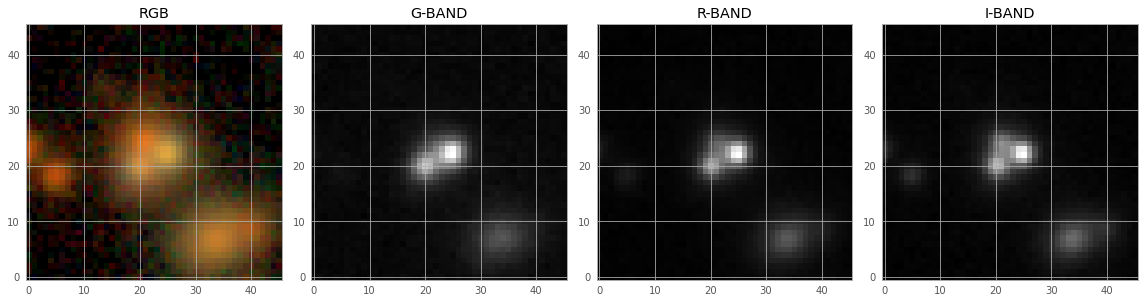

In [10]:
# find a section of the image to use for background
coadd_id = 1146879846
plot_all(coadd_id, image)


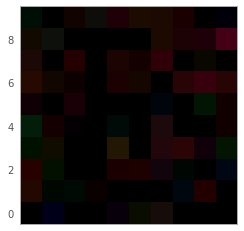

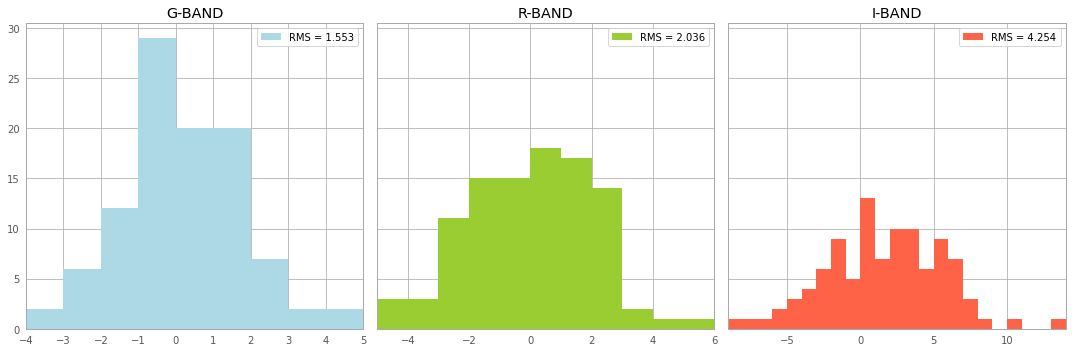

In [11]:
# get the background_rms and check that histograms look fine
crop = [[0, 10], [0, 10]]
rms_list = get_rms(filename, coadd_id, crop)


In [12]:
# DES camera specifics
exp_time = 90.  # exposure time
numPix = 46  # number of pixels in image
deltaPix = 0.2637  # pixel size in arcsec
psf_type = 'GAUSSIAN'  # gaussian estimate since we don't have a near-field star for a psf model

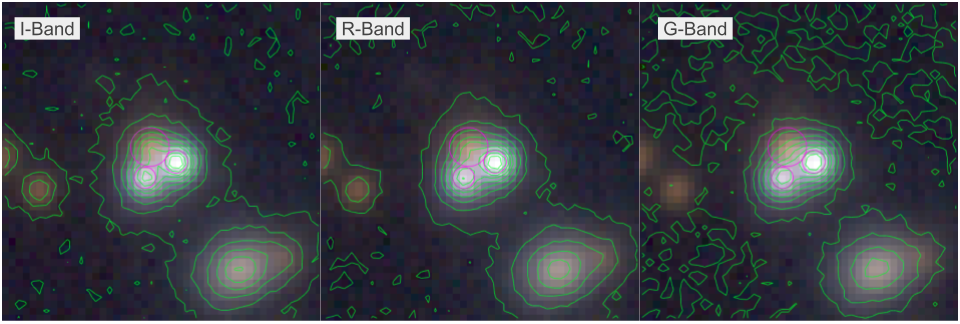

In [13]:
# measure image and lens positions:
x_images = [-0.60, 0.59]
y_images = [-0.70, -0.07]
center_x = -0.35
center_y = 0.37

# approximate an eistein radius:
theta_E = approx_theta_E(center_x, center_y, x_images, y_images)

# and add a mask
mask_list = [{'mask_x': 3.03 , 'mask_y': -4.09, 'mask_r':2.5}]

'Estimated theta_E': 1.07


In [18]:
# MODEL
def model(coadd_id, kwargs_lens_initial, kwargs_light_initial,
          x_images, y_images, psf_type, rms_list, mask_list):
    """
    INPUT: coadd_id,
           initial lens mass and light model params,
           image positions in arcsec,
           psf choice (GAUSSIAN or PIXEL),
           list of background rms values (ordered G,R,I),
           list of masks or None
    OUTPUT: RGB image,
            observed image, modeled image, normalized residuals, critical curves and caustics (each band)
            and results of PSO and MCMC fitting
    """
    # Image data
    data, image = get_data(filename)
    # index data frame by coadd_id
    row = data[data['COADD_OBJECT_ID'] == coadd_id].index[0]

    g = image[row, 0, :, :] # get image array
    r = image[row, 1, :, :]
    i = image[row, 2, :, :]

    fwhm_g = data.iloc[row, 27] # get fwhm
    fwhm_r = data.iloc[row, 28]
    fwhm_i = data.iloc[row, 29]

    rms_g = rms_list[0]  # get background_rms
    rms_r = rms_list[1]
    rms_i = rms_list[2]

    # set models to use
    # input for point source is image positions, not source position
    lens_model_list = ['SIE']
    lens_light_model_list = ['SERSIC_ELLIPSE']
    point_source_list = ['LENSED_POSITION']

    # generate coordinate grid and image properties
    ra_grid, dec_grid, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ = util.make_grid_with_coordtransform(numPix, deltaPix, subgrid_res=1, center_ra=0, center_dec=0, inverse=False)

    # generate image data for each band
    kwargs_data_g = {'background_rms': rms_g,  # calculated from background section
                     'exposure_time': exp_time,  # from DES camera
                     'ra_at_xy_0': ra_at_xy_0,
                     'dec_at_xy_0': dec_at_xy_0,
                     'transform_pix2angle': Mpix2coord,  # coords in ra, dec
                     'image_data': g}  # 2d image array

    kwargs_data_r = {'background_rms': rms_r,
                     'exposure_time': exp_time,
                     'ra_at_xy_0': ra_at_xy_0,
                     'dec_at_xy_0': dec_at_xy_0,
                     'transform_pix2angle': Mpix2coord,
                     'image_data': r}

    kwargs_data_i = {'background_rms': rms_i,
                     'exposure_time': exp_time,
                     'ra_at_xy_0': ra_at_xy_0,
                     'dec_at_xy_0': dec_at_xy_0,
                     'transform_pix2angle': Mpix2coord,
                     'image_data': i}

    # set kwargs_psf depending on psf_type
    if psf_type == 'GAUSSIAN':
        kwargs_psf_g = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm_g,
                        'pixel_size': deltaPix, 'truncation': 6}
        kwargs_psf_r = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm_r,
                        'pixel_size': deltaPix, 'truncation': 6}
        kwargs_psf_i = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm_i,
                        'pixel_size': deltaPix, 'truncation': 6}

    # psf from near field bright star
    elif psf_type == 'PIXEL':
        kwargs_psf_g = set_pixel_psf(coadd_id, 0)
        kwargs_psf_r = set_pixel_psf(coadd_id, 1)
        kwargs_psf_i = set_pixel_psf(coadd_id, 2)

    else:
        print("Invalid psf_type. Choose 'GAUSSIAN' or 'PIXEL'.")

    # Option to add mask(s)
    if mask_list:
        # get 2d grid for ra, dec
        ra_grid_2d = util.array2image(ra_grid)
        dec_grid_2d = util.array2image(dec_grid)

        # add each mask from mask_list
        for index in range(len(mask_list)):
            # generate mask
            mask = mask_list[index]
            mask_2d = mask_util.mask_center_2d(center_x=mask.get('mask_x'),
                                               center_y=mask.get('mask_y'),
                                               r=mask.get('mask_r'),
                                               x_grid=ra_grid_2d,
                                               y_grid=dec_grid_2d)
 
            # add mask to data in each band
            kwargs_data_g, g = add_mask(g, kwargs_data_g, kwargs_psf_g, mask_2d)
            kwargs_data_r, r = add_mask(r, kwargs_data_r, kwargs_psf_r, mask_2d)
            kwargs_data_i, i = add_mask(i, kwargs_data_i, kwargs_psf_i, mask_2d)
        
        # add masked arrays to likelihood
        image_likelihood_mask_list = [g, r, i]
        
        # plot each band with mask(s) for reference
        plot_image(g)
        plot_image(r)
        plot_image(i)

    elif mask_list == None:
        pass
    else:
        print('Please add mask or set mask_list=None')


    # Settings for model
    kwargs_numerics = {'supersampling_factor': 1,
                       'supersampling_convolution': False}

    # combine models
    kwargs_model = {'lens_model_list': lens_model_list,
                    'lens_light_model_list': lens_light_model_list,
                    'point_source_model_list': point_source_list,
                    'additional_images_list': [False],
                    'fixed_magnification_list': [False]}  # not modeling flux ratios here

    num_images = len(x_images)  # number of images
    kwargs_constraints = {'num_point_source_list': [num_images],
                          'joint_lens_with_light': [[0, 0, ['center_x', 'center_y']]]}  # lens mass and light will vary together now

    kwargs_likelihood = {'check_bounds': True,  # punish models outside upper/lower bounds
                         'force_no_add_image': False,  # allow the model to add images
                         'image_position_uncertainty': 0.01,  # 1 sigma gaussian uncertainty in image positions
                         'check_matched_source_position': True,  # check that the image positions trace back to the same source position
                         'check_positive_flux': True,  # punish models with non-physical fluxes
                         'source_position_tolerance': 0.01,
                         'source_position_sigma': 0.01,
                         'image_likelihood': True,
                         'image_likelihood_mask_list': image_likelihood_mask_list  # masks out likelihood
                        }


    # Combine bands for modeling
    g_band = [kwargs_data_g, kwargs_psf_g, kwargs_numerics]
    r_band = [kwargs_data_r, kwargs_psf_r, kwargs_numerics]
    i_band = [kwargs_data_i, kwargs_psf_i, kwargs_numerics]
    multi_band_list = [g_band, r_band, i_band]
    kwargs_data_joint = {'multi_band_list': multi_band_list,
                         'multi_band_type': 'multi-linear'}

    # Add parameters to model:
    # lens
    kwargs_lens_fixed = [{}]  # fixed parameters
    kwargs_lens_init = [kwargs_lens_initial]  # initial input
    kwargs_lens_sigma = [{'theta_E': 0.1, 'e1': 0.05, 'e2': 0.05,
                          'center_x': 0.01, 'center_y': 0.01}]  # step sizes
    kwargs_lower_lens = [{'theta_E': theta_E - 0.7, 'e1': -0.5, 'e2': -0.5,
                          'center_x': center_x - 0.2, 'center_y': center_y - 0.2}]  # lower bounds
    kwargs_upper_lens = [{'theta_E': theta_E + 0.7, 'e1': 0.5, 'e2': 0.5,
                          'center_x': center_x + 0.2, 'center_y': center_y + 0.2}]  # upper bounds

    # lens light
    kwargs_lens_light_fixed = [{}]
    kwargs_lens_light_init = [kwargs_light_initial]
    kwargs_lens_light_sigma = [{'R_sersic': 0.1, 'n_sersic': 0.1,
                                'e1': 0.05, 'e2': 0.05,
                                'center_x': 0.01, 'center_y': 0.01}]
    kwargs_lower_lens_light = [{'R_sersic': 0.01, 'n_sersic': 0.01,
                                'e1': -0.5, 'e2': -0.5,
                                'center_x': center_x-0.2, 'center_y': center_y-0.2}]
    kwargs_upper_lens_light = [{'R_sersic': 11, 'n_sersic': 10.,
                                'e1': 0.5, 'e2': 0.5,
                                'center_x': center_x+0.2, 'center_y': center_y+0.2}]

    # point source image positions
    fixed_ps = [{}]
    kwargs_ps_init = [{'ra_image': x_images,'dec_image': y_images}]
    kwargs_ps_sigma = [{'ra_image': [0.01] * num_images,
                        'dec_image': [0.01] * num_images}]
    kwargs_lower_ps = [{'ra_image': [i-0.2 for i in x_images],
                        'dec_image': [i-0.2 for i in y_images]}]
    kwargs_upper_ps = [{'ra_image': [i+0.2 for i in x_images],
                        'dec_image': [i+0.2 for i in y_images]}]

    # combine params
    lens_params = [kwargs_lens_init,
                   kwargs_lens_sigma,
                   kwargs_lens_fixed,
                   kwargs_lower_lens,
                   kwargs_upper_lens]

    lens_light_params = [kwargs_lens_light_init,
                         kwargs_lens_light_sigma,
                         kwargs_lens_light_fixed,
                         kwargs_lower_lens_light,
                         kwargs_upper_lens_light]

    ps_params = [kwargs_ps_init,
                 kwargs_ps_sigma,
                 fixed_ps,
                 kwargs_lower_ps,
                 kwargs_upper_ps]

    kwargs_params = {'lens_model': lens_params,
                     'lens_light_model': lens_light_params,
                     'point_source_model': ps_params}

    # Fitting
    # Combine everything from above for the fitting process
    fitting_seq = FittingSequence(kwargs_data_joint,
                              kwargs_model,
                              kwargs_constraints,
                              kwargs_likelihood,
                              kwargs_params)
    
    # General Settings
    particles = 400
    iterations = 400
    burn = 200
    run = 600

    # PSO Settings
    PSO_list = ['PSO', {'sigma_scale': 1.,
                        'n_particles': particles,
                        'n_iterations': iterations}]

    # MCMC Settings
    MCMC_list = ['MCMC', {'n_burn': burn, 'n_run': run,
                          'walkerRatio': 10, 'sigma_scale': .1}]

    fitting_kwargs_list = [PSO_list, MCMC_list]  # we are running a PSO, then the MCMC
    
    chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
    kwargs_result = fitting_seq.best_fit()

    # Show final results
    print(f"ra_images: {np.around(kwargs_result.get('kwargs_ps')[0].get('ra_image'), 2)}")
    print(f"dec_images: {np.around(kwargs_result.get('kwargs_ps')[0].get('dec_image'), 2)}")

    # plotting settings
    modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, image_likelihood_mask_list,
                          arrow_size=0.02, cmap_string="gist_heat")

    # plot RGB image
    rgb_image = ap.visualization.make_lupton_rgb(i, r, g, stretch=50, Q=10)
    plot_image(rgb_image)

    # plot observed, reconstructed, normalized residuals, and critical curves for each band
    model_plot_all_bands_withCC(modelPlot, kwargs_result)
    
    # Results of MCMC chain
    sampler_type, samples_mcmc, param_mcmc, dist_mcmc = chain_list[1]
    for i in range(len(chain_list)):
        chain_plot.plot_chain_list(chain_list, i)

    print("number of non-linear parameters in the MCMC process: ", len(param_mcmc))
    print("parameters in order: ", param_mcmc)
    print("number of evaluations in the MCMC process: ", np.shape(samples_mcmc)[0])
    n_sample = len(samples_mcmc)
    print(n_sample)
    samples_mcmc_cut = samples_mcmc[int(n_sample * 1/2.):]

    n, num_param = np.shape(samples_mcmc_cut)
    plot = corner.corner(samples_mcmc_cut[:, :], labels=param_mcmc[:], show_titles=True)


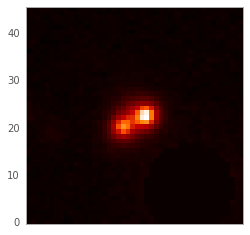

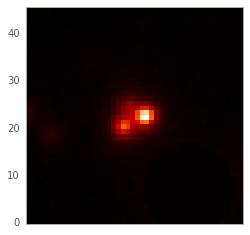

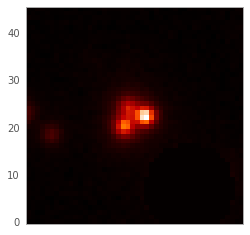

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
Converged after 343 iterations!
Best fit found:  -18580.973545443827 [1.0560873154084431, 0.12244130414116654, 0.06364589940498389, 3.7470775284438584, 4.860982085317896, -0.02552478061627549, -0.025731881297641507, -0.2887457130719628, 0.2091393315035128, -0.6215626922448364, 0.6183745638795444, -0.7206110967156321, -0.06042977174848886]
-6.737118761944825 reduced X^2 of best position
-18580.973545443827 logL
5516.0 effective number of data points
[{'theta_E': 1.0560873154084431, 'e1': 0.12244130414116654, 'e2': 0.06364589940498389, 'center_x': -0.2887457130719628, 'center_y': 0.2091393315035128}] lens result
[] source result
[{'amp': 1, 'R_sersic': 3.7470775284438584, 'n_sersic': 4.860982085317896, 'e1': -0.02552478061627549, 'e2': -0.025731881297641507, 'center_x': -0.2887457130719628, 'center_y': 0.2091393315035128}] lens light result


100%|█████████████████████████████████████████| 800/800 [09:37<00:00,  1.39it/s]

Computing the MCMC...
Number of walkers =  130
Burn-in iterations:  200
Sampling iterations (in current run): 800
577.8623759746552 time taken for MCMC sampling
ra_images: [-0.62  0.62]
dec_images: [-0.72 -0.06]
-6.710508734580292 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  2.7528301253349
reduced chi^2 of data  1 =  9.191527950999301
reduced chi^2 of data  2 =  8.187168127406673



/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:43: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)


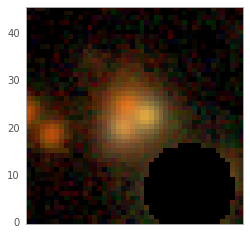

The ray traced source positions are: 
ra: [-0.35884149 -0.35896302]
dec: [0.3515519  0.35137836]


/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:136: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(self._model), origin='lower', vmin=v_min, vmax=v_max,
/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning

Check Positions: True
Check Fluxes: True
Check Positions: True
Check Fluxes: True
Check Positions: True
Check Fluxes: True


/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:136: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(self._model), origin='lower', vmin=v_min, vmax=v_max,


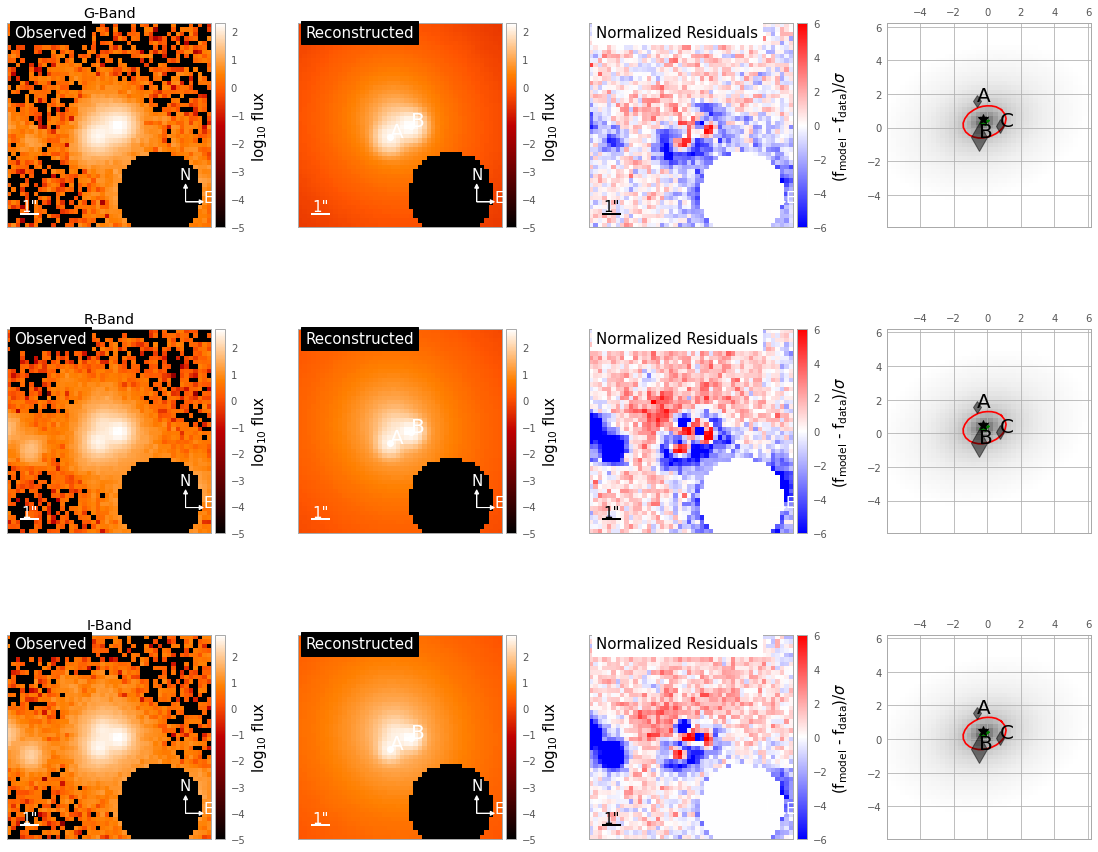

number of non-linear parameters in the MCMC process:  13
parameters in order:  ['theta_E_lens0', 'e1_lens0', 'e2_lens0', 'R_sersic_lens_light0', 'n_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0', 'ra_image', 'ra_image', 'dec_image', 'dec_image']
number of evaluations in the MCMC process:  78000
78000


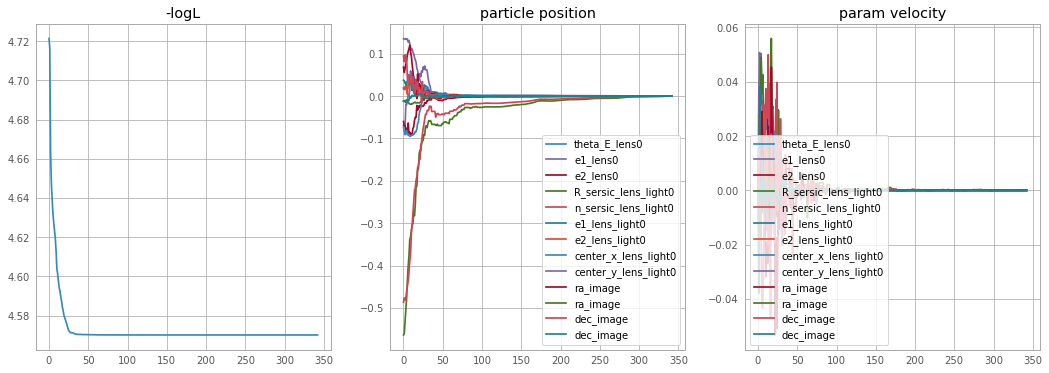

<Figure size 432x288 with 0 Axes>

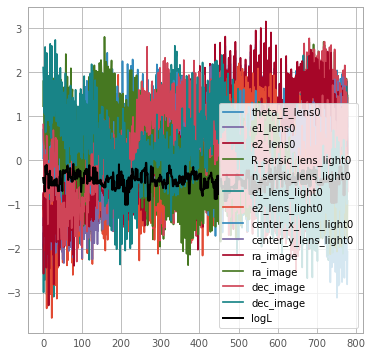

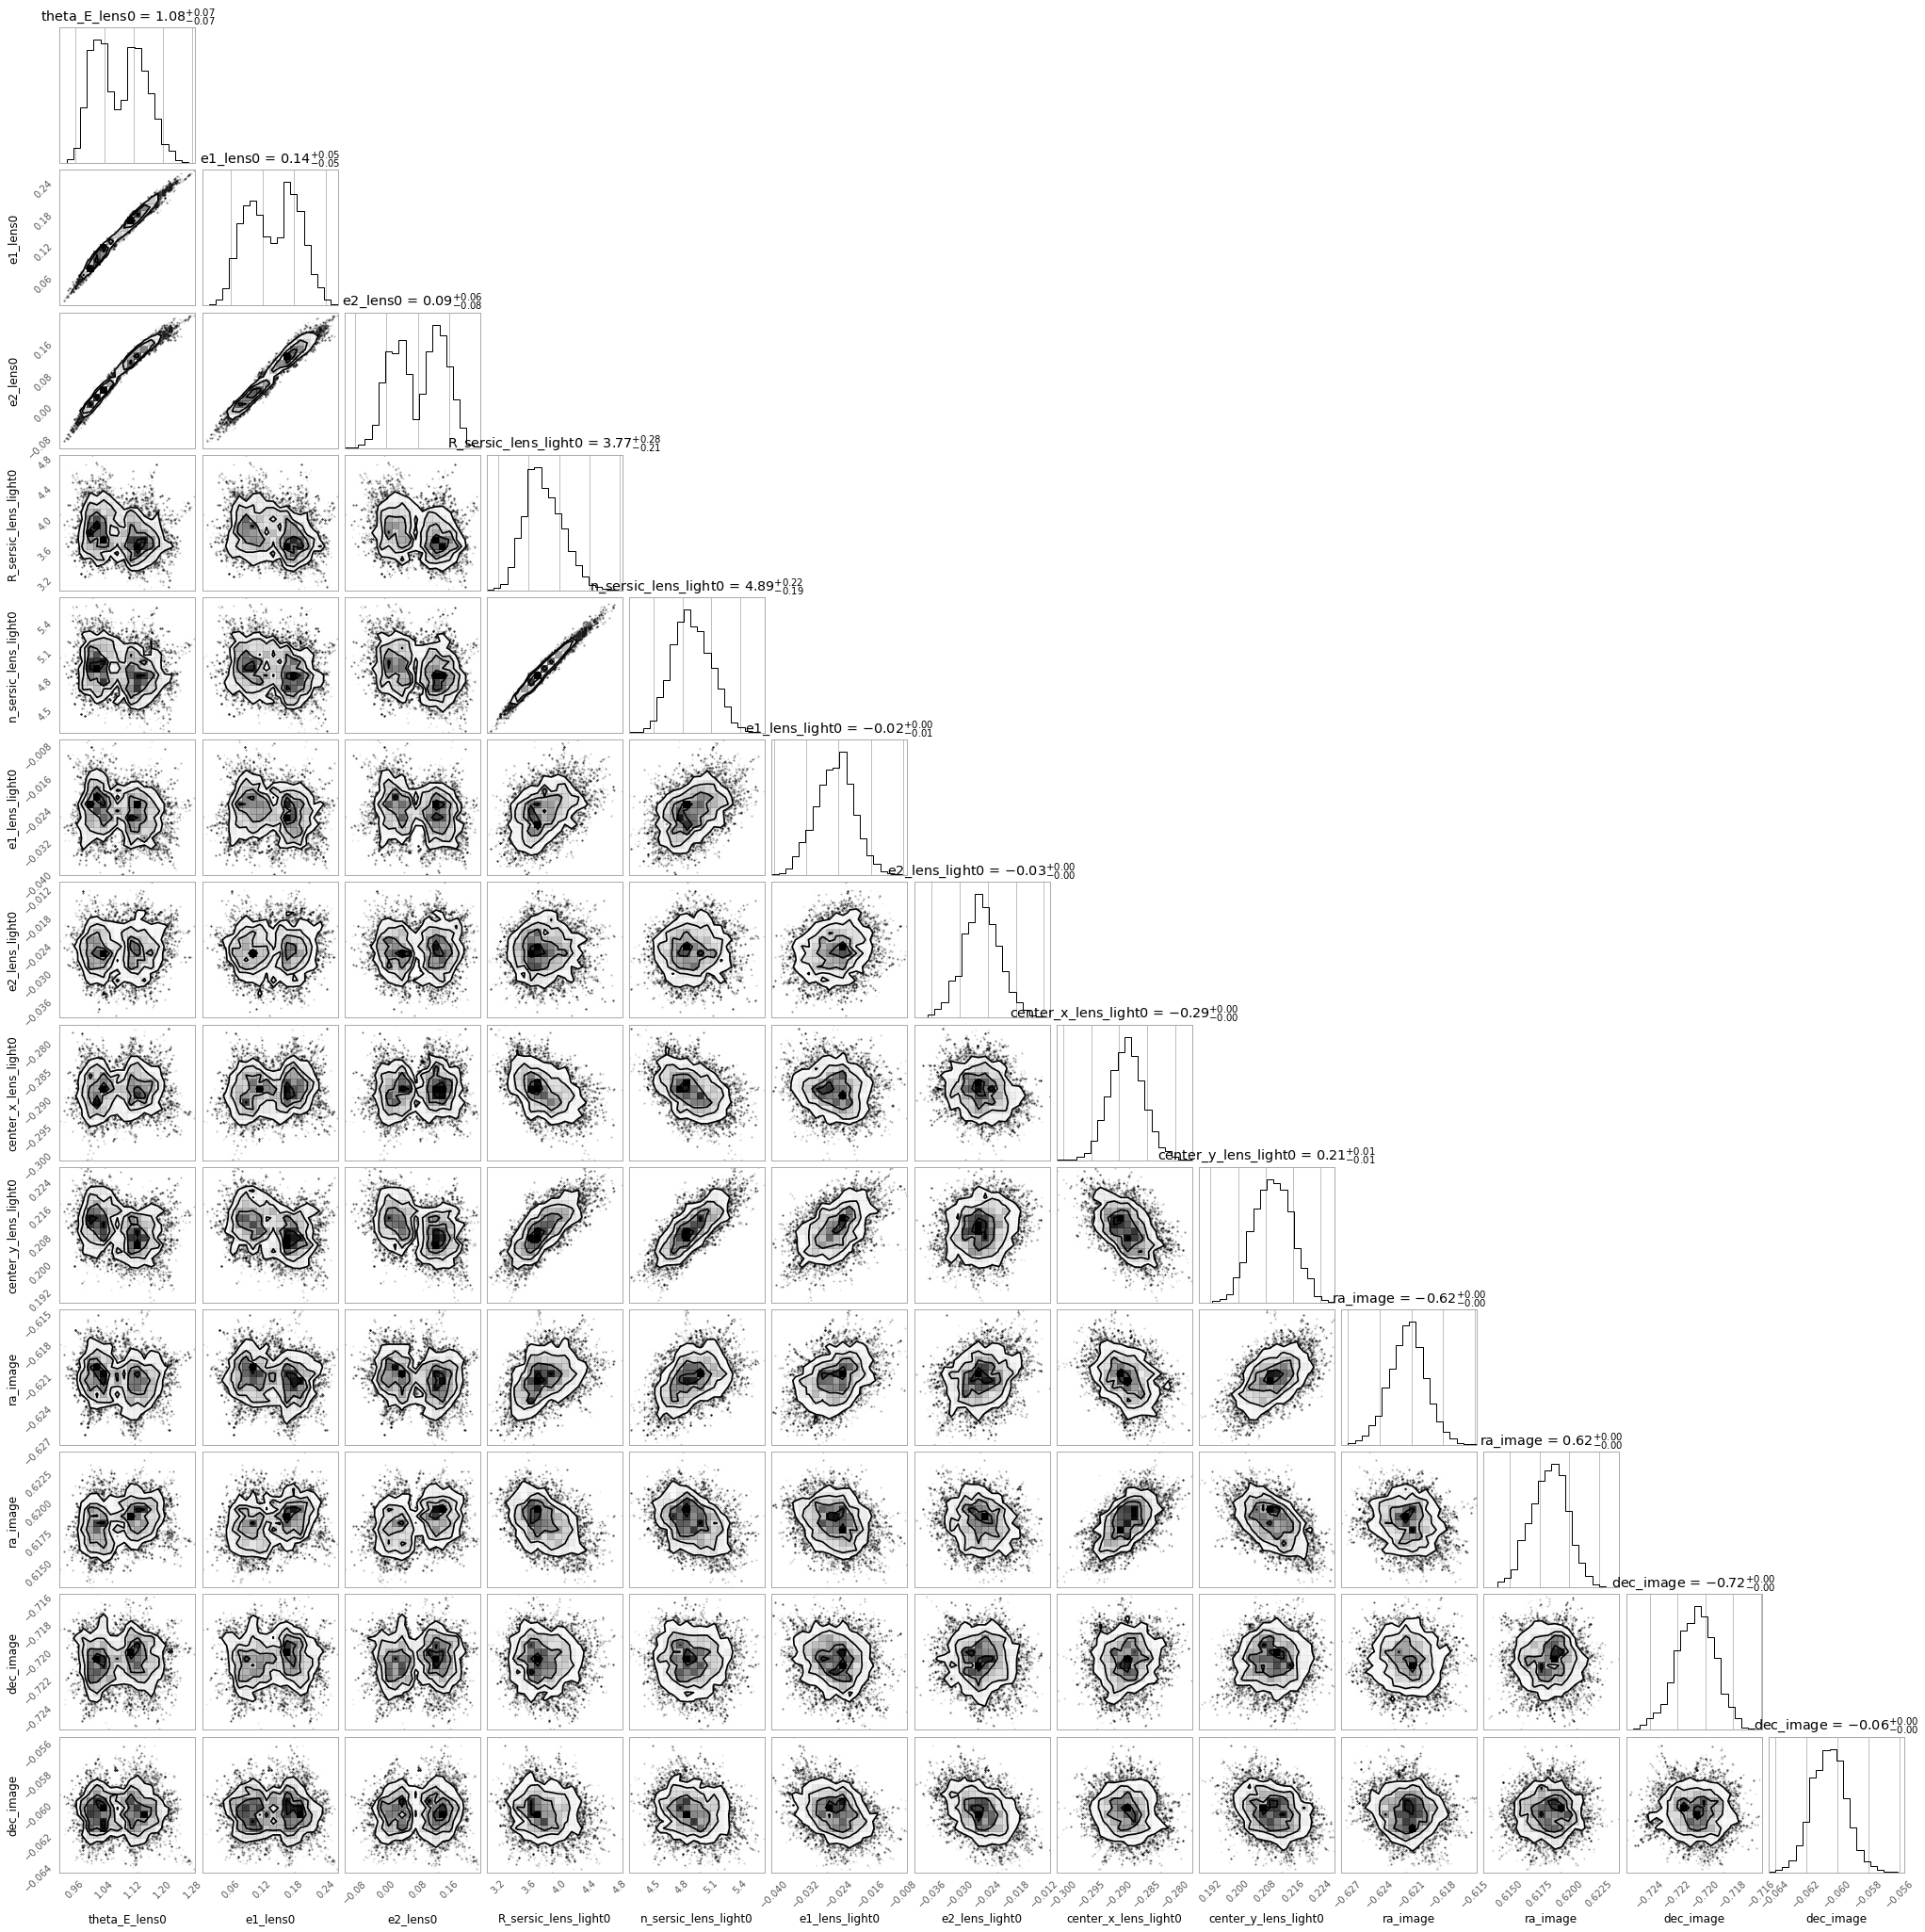

In [19]:
# set initial parameters
kwargs_lens_initial = {'theta_E': theta_E, 'e1': 0., 'e2': 0.,
                       'center_x': center_x, 'center_y': center_y}

kwargs_light_initial = {'R_sersic': 1., 'n_sersic': 2.,
                        'e1': 0., 'e2': 0.,
                        'center_x': center_x, 'center_y': center_y}

# run the model on the data
model(coadd_id, kwargs_lens_initial, kwargs_light_initial,
      x_images, y_images, psf_type, rms_list, mask_list)

Based on the corner plot, it seems like our model is fitting well! We also see that our source position is being ray-traced back to approximately the same location, and the model is returning positive flux values. However, the residuals show many patterns, especially around the objects. We also see double-peaks in the histograms for theta_E, e1, and e2, so lets move onto Step 6, Troubleshooting.